# 💡 Introduction

This notebook demonstrates how Dutch **Standard Load Profiles (SLPs)** can be used to construct a **representative electricity demand profile** for a municipality.

The case study used here is **Alkmaar**, but the methodology is generic and can be applied to any municipality or spatial aggregation level (e.g. PC6, neighborhoods).


## Environment setup

We install and import the required Python packages.  
`illuminator` is used to maintain compatibility with the project’s simulation framework, while `pandas` and `matplotlib` are used for data handling and visualization.

`nest_asyncio` is applied to avoid event loop conflicts when running simulations inside Jupyter notebooks.


In [1]:
# installing illuminator
!pip install illuminator


In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import nest_asyncio
nest_asyncio.apply()

## Reading and structuring Dutch Standard Load Profiles

This block reads the ENERGIEDATA WIJZER Dutch electricity SLP file and performs preprocessing steps:

- extracts the SLP profile names from the file header,
- reads the quarter-hourly time series data,
- assigns clean column names,
- parses the timestamp column and sets it as the DataFrame index.

The resulting DataFrame contains quarter-hourly SLP fractions for the full year,
ready to be scaled and used in the load model.



In [3]:
# Path to SLP file
csv_path = Path("data") / "Standaardprofielen elektriciteit 2026 versie 1.00.csv"

# --- Read SLP header to extract profile names ---
with open(csv_path, "r", encoding="utf-8-sig") as f:
    header_line = f.readline().strip()

parts = header_line.split(";")
raw_names = [p for p in parts[3:] if p != ""]
profile_names = [n.split("_", 1)[1] if "_" in n else n for n in raw_names]

# --- Read SLP time series data ---
df = pd.read_csv(
    csv_path,
    sep=";",
    encoding="utf-8-sig",
    decimal=".",
    skiprows=7,
    header=None
)

# Drop trailing empty column if present
if df.iloc[:, -1].isna().all():
    df = df.iloc[:, :-1]

# Assign column names
df.columns = ["time", "from", "to"] + profile_names

# Parse time column and set index
df["time"] = pd.to_datetime(df["time"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["time"]).set_index("time")
df.index.name = "time"

print(df.columns[:10])


Index(['from', 'to', 'E1A_AZI_A', 'E1A_AZI_I', 'E1A_AMI_A', 'E1A_AMI_I',
       'E1B_AZI_A', 'E1B_AZI_I', 'E1B_AMI_A', 'E1B_AMI_I'],
      dtype='object')


## Helper functions

Two helper functions are defined:
- one to **run a load model for a full year**,
- one to **plot a specific day** from a yearly time series.


In [4]:
def run_load_model_year(load_model, index, step_seconds=900, inputs=None, output_key="load_dem"):
    """
    Run the Load model for every timestep in 'index' and return a numeric Series.

    output_key: which output to store ('load_dem' or 'consumption')
    """
    if inputs is None:
        inputs = {"load": 0}

    def to_float(x):
        # If it's already numeric
        if isinstance(x, (int, float)):
            return float(x)
        # If it's a dict (message wrapper or nested output), try common patterns
        if isinstance(x, dict):
            if output_key in x:
                return float(x[output_key])
            # sometimes value is stored under 'value'
            if "value" in x:
                return float(x["value"])
        # Last resort: try casting
        return float(x)

    values = []
    for i in range(len(index)):
        t = i * step_seconds
        load_model.step(time=t, inputs=inputs)

        out = load_model._model.outputs.get(output_key)
        values.append(to_float(out))

    return pd.Series(values, index=index, name=output_key)


In [5]:
def plot_day_from_year(series_year, day, ylabel="load_dem"):
    """
    Plot a specific calendar day from a full-year time series.
    """
    day = pd.to_datetime(day).date()
    s_day = series_year.loc[series_year.index.date == day]

    if s_day.empty:
        raise ValueError(f"No rows found for {day}")

    plt.figure(figsize=(12, 4))
    plt.plot(s_day.index, s_day.values)
    plt.title(f"{ylabel} on {day}")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return s_day


## Load model with SLP-based demand

A custom `Load` model is implemented following Illuminator conventions.
When `slp_enabled=True`, the model internally generates quarter-hourly demand
from SLP fractions scaled by annual electricity consumption.


In [9]:
from illuminator.builder import ModelConstructor

class Load(ModelConstructor):
    """
    Calculates total load demand based on number of houses and input load.

    Two modes:
    - slp_enabled=True:
        Generates per-house load internally from SLP fractions (slp_df) and annual_kwh.
        Ignores external input 'load'. (SLP wins)

    - slp_enabled=False:
        Uses external per-house input 'load'.
        Works both:
          (a) inside Simulation (Illuminator message format via unpack_inputs)
          (b) in notebooks (plain dict like {'load': 0})
    """

    parameters = {
        "houses": 1,
        "input_type": "energy",
        "output_type": "power",

        "slp_enabled": False,
        "slp_df": None,
        "category": "E1A",
        "pv": False,
        "direction": "A",
        "annual_kwh": 2270.0,

        "step_seconds": 900,
    }

    inputs = {"load": 0}
    outputs = {"load_dem": 0, "consumption": 0}
    states = {"time": None, "forecast": None}

    time_step_size = 1
    time = None

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # Helper: prefer explicit kwargs, then _model.parameters, then default
        def get_param(name, default):
            if name in kwargs:
                return kwargs[name]
            return self._model.parameters.get(name, default)

        self.consumption = 0

        self.houses = int(get_param("houses", 1))
        self.input_type = get_param("input_type", "power")
        self.output_type = get_param("output_type", "energy")

        if self.input_type not in ["power", "energy"]:
            raise ValueError(f"Invalid input_type: {self.input_type}. Must be 'power' or 'energy'.")
        if self.output_type not in ["power", "energy"]:
            raise ValueError(f"Invalid output_type: {self.output_type}. Must be 'power' or 'energy'.")

        # SLP parameters
        self.slp_enabled = bool(get_param("slp_enabled", False))
        self.slp_df = get_param("slp_df", None)
        self.category = get_param("category", "E1A")
        self.pv = get_param("pv", False)
        self.direction = get_param("direction", "A")
        self.annual_kwh = float(get_param("annual_kwh", 2270.0))
        self.step_seconds = int(get_param("step_seconds", 900))

        if self.direction not in ["A", "I"]:
            raise ValueError("direction must be 'A' or 'I'")
        if self.pv not in [True, False]:
            raise ValueError("pv must be True or False")
        if self.annual_kwh < 0:
            raise ValueError("annual_kwh must be >= 0")
        if self.step_seconds <= 0:
            raise ValueError("step_seconds must be > 0")

        # Precompute SLP series if enabled
        self._slp_series_kwh_step = None
        if self.slp_enabled:
            if self.slp_df is None:
                raise ValueError("slp_enabled=True requires slp_df to be provided")

            meter_type = "AMI" if self.pv else "AZI"
            self.slp_col = f"{self.category}_{meter_type}_{self.direction}"

            if self.slp_col not in self.slp_df.columns:
                raise KeyError(f"SLP column '{self.slp_col}' not found in slp_df")

            self._slp_series_kwh_step = self.slp_df[self.slp_col] * self.annual_kwh

    def _read_plain_load_input(self, inputs):
        """
        Notebook friendly: accept inputs like {'load': 0.0} directly.
        """
        if inputs is None:
            return 0.0
        val = inputs.get("load", 0.0)
        try:
            return float(val)
        except Exception:
            return 0.0

    def step(self, time: int, inputs: dict = None, max_advance: int = 900) -> None:
        self.time = time

        if self.slp_enabled:
            step_i = int(time / self.step_seconds)
            if step_i < 0:
                step_i = 0
            if step_i >= len(self._slp_series_kwh_step):
                step_i = len(self._slp_series_kwh_step) - 1

            per_house_energy = float(self._slp_series_kwh_step.iloc[step_i])

            if self.input_type == "energy":
                load_in = per_house_energy
            else:
                deltaTime = self.step_seconds / 3600.0
                load_in = per_house_energy / deltaTime

        else:
            # If it looks like an Illuminator message structure, use unpack_inputs.
            # Otherwise, treat it as a plain notebook dict.
            use_unpack = False
            if isinstance(inputs, dict):
                v = inputs.get("load", None)
                # message format is nested dicts, not a number
                if isinstance(v, dict):
                    use_unpack = True

            if use_unpack:
                input_data = self.unpack_inputs(inputs)
                load_in = input_data.get("load", 0)
            else:
                load_in = self._read_plain_load_input(inputs)

        results = self.demand(load=load_in)
        self.set_outputs(results)
        return time + self._model.time_step_size

    def demand(self, load: float) -> dict:
        deltaTime = self.step_seconds / 3600.0

        if self.input_type == "power":
            if self.output_type == "power":
                self.consumption = self.houses * load
            else:
                self.consumption = self.houses * load * deltaTime
        else:
            if self.output_type == "power":
                self.consumption = self.houses * load / deltaTime
            else:
                self.consumption = self.houses * load

        return {"load_dem": self.consumption, "consumption": self.consumption}


## Annual electricity consumption data

Aggregated statistics provide:
- total number of dwellings,
- PV penetration rate,
- average annual grid electricity import
  for households with and without PV.

These values are used to scale the SLPs.


In [10]:
annual_path = Path("data") / "Annual_Energy_Consumption.csv"

# Read as raw text first to detect delimiter (; vs ,)
with open(annual_path, "r", encoding="utf-8-sig") as f:
    first_line = f.readline()

sep = ";" if first_line.count(";") > first_line.count(",") else ","

annual_df = pd.read_csv(
    annual_path,
    sep=sep,
    encoding="utf-8-sig",
    decimal=".",     # change to "," only if you know decimals are comma in this file
)

# Clean up column names (strip spaces + remove BOM if present)
annual_df.columns = annual_df.columns.astype(str).str.strip().str.replace("\ufeff", "", regex=False)

# Keep only the first data row (your file is 1 row anyway)
row = annual_df.iloc[0]

total_houses = int(row["Totaal woningen"])
pv_share_pct = float(row["Aandeel woningen zonnestroom op adres (%)"])

annual_kwh_with_pv = float(row["With_PV_Elektriciteitslevering/Gemiddelde elektriciteitslevering (gemiddeld kWh)"])
annual_kwh_no_pv   = float(row["Elektriciteitslevering/Gemiddelde elektriciteitslevering (gemiddeld kWh)"])

houses_with_pv = int(round(total_houses * pv_share_pct / 100.0))
houses_no_pv = total_houses - houses_with_pv

print("Delimiter detected:", sep)
print("Total houses:", total_houses)
print("PV share (%):", pv_share_pct)
print("Houses with PV:", houses_with_pv)
print("Houses without PV:", houses_no_pv)
print("Annual kWh with PV:", annual_kwh_with_pv)
print("Annual kWh without PV:", annual_kwh_no_pv)


Delimiter detected: ;
Total houses: 54739
PV share (%): 36.0
Houses with PV: 19706
Houses without PV: 35033
Annual kWh with PV: 3050.0
Annual kWh without PV: 2270.0


## Defining household groups

Two representative household groups are modeled:
- households **with PV** (AMI profiles),
- households **without PV** (AZI profiles).

Each group is represented by one aggregated load model.


In [11]:
# Load representing houses WITH PV (AMI)
load_with_pv = Load(
    houses=houses_with_pv,
    input_type="energy",
    output_type="energy",      # kWh per 15 min
    slp_enabled=True,
    slp_df=df,
    category="E1A",
    pv=True,                   # -> AMI
    direction="A",
    annual_kwh=annual_kwh_with_pv
)

# Load representing houses WITHOUT PV (AZI)
load_no_pv = Load(
    houses=houses_no_pv,
    input_type="energy",
    output_type="energy",      # kWh per 15 min
    slp_enabled=True,
    slp_df=df,
    category="E1A",
    pv=False,                  # -> AZI
    direction="A",
    annual_kwh=annual_kwh_no_pv
)

print("PV load uses SLP:", load_with_pv.slp_col)
print("No-PV load uses SLP:", load_no_pv.slp_col)


PV load uses SLP: E1A_AMI_A
No-PV load uses SLP: E1A_AZI_A


In [12]:
year_load_with_pv = run_load_model_year(
    load_with_pv,
    df.index,
    output_key="load_dem"
)

year_load_no_pv = run_load_model_year(
    load_no_pv,
    df.index,
    output_key="load_dem"
)

year_load_total = year_load_with_pv + year_load_no_pv

## Validation and visualization

The annual energy balance is checked against input statistics.
Finally, quarter-hourly load profiles are visualized for a selected day.


In [13]:
print("PV group annual kWh (model):", year_load_with_pv.sum())
print("PV group annual kWh (target):", houses_with_pv * annual_kwh_with_pv)

print("No-PV group annual kWh (model):", year_load_no_pv.sum())
print("No-PV group annual kWh (target):", houses_no_pv * annual_kwh_no_pv)

print("Total annual kWh (model):", year_load_total.sum())
print("Total annual kWh (target):",
      houses_with_pv * annual_kwh_with_pv + houses_no_pv * annual_kwh_no_pv)


PV group annual kWh (model): 60103235.088436
PV group annual kWh (target): 60103300.0
No-PV group annual kWh (model): 79524843.1990756
No-PV group annual kWh (target): 79524910.0
Total annual kWh (model): 139628078.2875116
Total annual kWh (target): 139628210.0


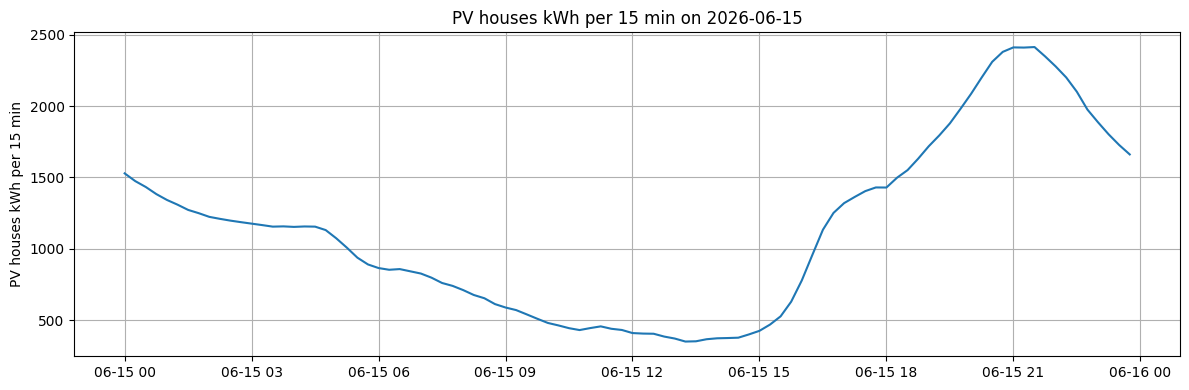

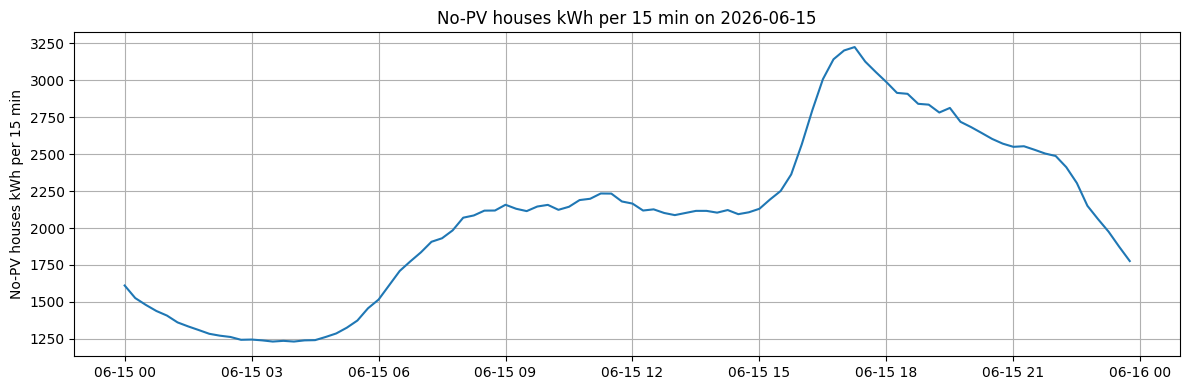

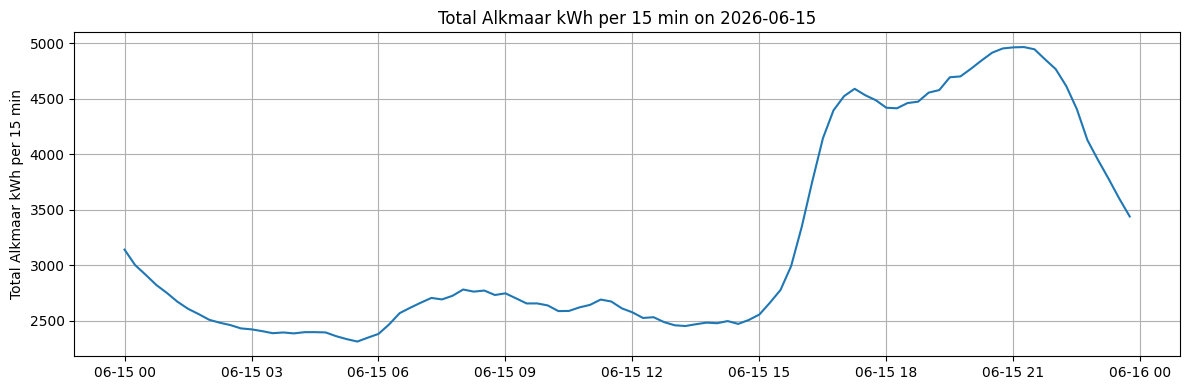

time
2026-06-15 00:00:00    3139.601596
2026-06-15 00:15:00    3000.416972
2026-06-15 00:30:00    2912.821247
2026-06-15 00:45:00    2821.582555
2026-06-15 01:00:00    2749.697596
                          ...     
2026-06-15 22:45:00    4125.949037
2026-06-15 23:00:00    3947.133005
2026-06-15 23:15:00    3777.896731
2026-06-15 23:30:00    3600.975722
2026-06-15 23:45:00    3437.841701
Name: load_dem, Length: 96, dtype: float64

In [15]:
plot_day_from_year(
    year_load_with_pv,
    "2026-06-15",
    ylabel="PV houses kWh per 15 min"
)

plot_day_from_year(
    year_load_no_pv,
    "2026-06-15",
    ylabel="No-PV houses kWh per 15 min"
)

plot_day_from_year(
    year_load_total,
    "2026-06-15",
    ylabel="Total Alkmaar kWh per 15 min"
)
